In [233]:
from parcels import (FieldSet, AdvectionRK4, BrownianMotion2D, plotTrajectoriesFile, Field,
                     ParticleSet, JITParticle, Variable, ErrorCode)
import numpy as np
import scipy as sc
import math
from datetime import timedelta, datetime
from operator import attrgetter
import copy_plottrajectoriesfile as cpt
import matplotlib.animation as animation
import imageio #to make .gif out of multiple .png
import matplotlib.pyplot as plt
import scipy.io as sio #to load matlab file

"""
Load IMOS raw data
"""
filenames = "../raw_imos_current_data/IMOS_OceanCurrent_HV_2019_C-20190520T232835Z.nc"
variables = {'U' : 'UCUR',
                'V' : 'VCUR'}
dimensions = {'lat' : 'LATITUDE',
                  'lon' : 'LONGITUDE',
                  'time' : 'TIME'}
fieldset_imos = FieldSet.from_netcdf(filenames, variables, dimensions, deferred_load=False)

"""
Take TIME variable from the IMOS raw data
"""
from netCDF4 import Dataset
dataset=Dataset(filenames)
print(dataset.variables['TIME'])
time_imos=np.array(dataset.variables['TIME'])

<class 'netCDF4._netCDF4.Variable'>
float64 TIME(TIME)
    long_name: analysis time
    standard_name: time
    units: days since 1985-01-01 00:00:00+00:00
    coordinate_type: TIME
    calendar: gregorian
unlimited dimensions: TIME
current shape = (111,)
filling on, default _FillValue of 9.969209968386869e+36 used



In [499]:
dataset.variables['UCUR']

<class 'netCDF4._netCDF4.Variable'>
int16 UCUR(TIME, LATITUDE, LONGITUDE)
    long_name: eastward geostrophic velocity
    standard_name: surface_geostrophic_eastward_sea_water_velocity
    description: computed from GSL, includes the time-mean
    units: m/s
    coordinates: TIME LATITUDE LONGITUDE
    _FillValue: -32766
    missing_value: -32766
    scale_factor: 0.00015259487586406848
    add_offset: 0.0
unlimited dimensions: TIME
current shape = (111, 351, 641)
filling on

In [501]:
np.min(dataset['UCUR'])

-32766.0

In [286]:
"""
Change U and V shape 
"""

i_lat_min=list(fieldset_imos.U.lat).index(-36)
i_lat_max=list(fieldset_imos.U.lat).index(-24)+1

i_lon_min=list(fieldset_imos.U.lon).index(150)
i_lon_max=list(fieldset_imos.U.lon).index(160)+1

lati=fieldset_imos.U.lat[i_lat_min:i_lat_max]
longi=fieldset_imos.U.lon[i_lon_min:i_lon_max]
ucur=fieldset_imos.U.data
vcur=fieldset_imos.V.data
u_imos=[]
v_imos=[]
grid_imos=[[],[]]
grid_lat=[]
grid_lon=[]

for i in range(len(lati)): #Create grid of IMOS latitude longitude
    for j in range(len(longi)):
        grid_imos[0].append(lati[i])
        grid_imos[1].append(longi[j]) 
grid_imos=np.asarray(grid_imos).T

for t in range(len(ucur)): #for every time step
    values_u=[]
    values_v=[]
    for i in range(i_lat_min,i_lat_max): #take U and V for every couple (lati,longi)
        for j in range(i_lon_min,i_lon_max):
            values_u.append(ucur[t,i,j])
            values_v.append(vcur[t,i,j])
    u_imos.append(np.asarray(values_u))
    v_imos.append(np.asarray(values_v))


    
"""
Create grid for extrapolated data #(resolution 0.1 degree)
"""
grid_lat_ext,grid_lon_ext = np.mgrid[-36:-24:0.1, 150:160:0.1] 
grid_ext=(grid_lat_ext,grid_lon_ext)

In [287]:
len(ucur)

111

In [288]:
"""
Extrapolate U and V data from grid_imos to grid_exp for each time step
"""

u_ext=[[] for i in range(len(u_imos))]
v_ext=[[] for i in range(len(v_imos))]
for i in range(len(u_imos)):
    u_ext[i] = sc.interpolate.griddata(grid_imos, u_imos[i], grid_ext, method='linear')
    v_ext[i] = sc.interpolate.griddata(grid_imos, v_imos[i], grid_ext, method='linear')
    print("number "+str(i)+" done")

number 0 done
number 1 done
number 2 done
number 3 done
number 4 done
number 5 done
number 6 done
number 7 done
number 8 done
number 9 done
number 10 done
number 11 done
number 12 done
number 13 done
number 14 done
number 15 done
number 16 done
number 17 done
number 18 done
number 19 done
number 20 done
number 21 done
number 22 done
number 23 done
number 24 done
number 25 done
number 26 done
number 27 done
number 28 done
number 29 done
number 30 done
number 31 done
number 32 done
number 33 done
number 34 done
number 35 done
number 36 done
number 37 done
number 38 done
number 39 done
number 40 done
number 41 done
number 42 done
number 43 done
number 44 done
number 45 done
number 46 done
number 47 done
number 48 done
number 49 done
number 50 done
number 51 done
number 52 done
number 53 done
number 54 done
number 55 done
number 56 done
number 57 done
number 58 done
number 59 done
number 60 done
number 61 done
number 62 done
number 63 done
number 64 done
number 65 done
number 66 done
numbe

In [289]:
"""
time_imos float to datetime object
"""

time=[]
for i in range(len(time_imos)):
    time.append(datetime.timestamp(datetime(1985,1,1,0,0,0)+timedelta(days=time_imos[i])))
    
a=[datetime.fromtimestamp(t) for t in time]

In [369]:
"""
Put extrapolated data in a dataset
"""

import xarray as xr
u=xr.DataArray(u_ext,
                dims=['time','lat','lon'],
                coords={'time':a,
                        'lat':np.arange(-36,-24,0.1),
                        'lon':np.arange(150,160,0.1)},)     

v=xr.DataArray(v_ext,
                dims=['time','lat','lon'],
                coords={'time':a,
                        'lat':np.arange(-36,-24,0.1),
                        'lon':np.arange(150,160,0.1)},)   

ds_ext=u.to_dataset(name='u_cur')
ds_ext['v_cur']=v

m = Basemap()
mask_lat, mask_lon = m(grid_lat_ext,grid_lon_ext)

"""
Create mask
"""
from global_land_mask import globe 
is_on_land = globe.is_land(mask_lat,mask_lon)

mask_ocean = 2 * np.ones((ds_ext.dims['lat'], ds_ext.dims['lon'])) * np.isfinite(ds_ext.u_cur.isel(time=0))  
mask_land = 1 * np.ones((ds_ext.dims['lat'], ds_ext.dims['lon'])) * is_on_land 
mask_array = mask_land + mask_ocean 
mask_array.plot()

ds_ext.coords['mask'] = (('lat', 'lon'), mask_array) 
ds_ext['u_cur_masked']=ds_ext['u_cur'].where(ds_ext.mask==2)
ds_ext['v_cur_masked']=ds_ext['v_cur'].where(ds_ext.mask==2)

In [503]:
ds_ext.mask

<xarray.DataArray 'mask' (lat: 120, lon: 100)>
array([[3., 3., 2., ..., 2., 2., 2.],
       [3., 3., 2., ..., 2., 2., 2.],
       [3., 3., 3., ..., 2., 2., 2.],
       ...,
       [3., 3., 3., ..., 2., 2., 2.],
       [3., 3., 3., ..., 2., 2., 2.],
       [3., 3., 3., ..., 2., 2., 2.]])
Coordinates:
  * lat      (lat) float64 -36.0 -35.9 -35.8 -35.7 ... -24.4 -24.3 -24.2 -24.1
  * lon      (lon) float64 150.0 150.1 150.2 150.3 ... 159.6 159.7 159.8 159.9
    mask     (lat, lon) float64 3.0 3.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0

In [296]:
from parcels import (FieldSet, AdvectionRK4, BrownianMotion2D, plotTrajectoriesFile, Field,
                     ParticleSet, JITParticle, Variable, ErrorCode)

In [297]:
def LimitBoundaries(lon_i, lat_i, lon_min): #return lon and lat for every lon>lon_min
    newlat=[]
    newlon=[]
    for i in range (0,len(lat_i)):
        if (lon_i[i]>lon_min):
            newlat.append(lat_i[i])
            newlon.append(lon_i[i])
    return newlon, newlat



"""Load & read Matlab file"""
mat_boundaries = sio.loadmat('../../nsw_boundaries/raw_nsw_boundaries/NSW_boundary.mat')
lat_nsw=mat_boundaries['lat_nsw'][0]
lon_nsw=mat_boundaries['lon_nsw'][0]
lon_nsw, lat_nsw = LimitBoundaries(lon_nsw, lat_nsw, 149.5)

plt.plot(lon_nsw, lat_nsw)
plt.show()

In [323]:
"""
Create fieldset with extrapolated data
"""

variables = {'U' : 'u_cur_masked',
            'V' : 'v_cur_masked'}
dimensions = {'lon' : 'lon',
              'lat' : 'lat',
              'time' : 'time'} 

fieldset_ext = FieldSet.from_xarray_dataset(ds_ext, variables, dimensions, allow_time_extrapolation=True)

In [299]:
time_ext[1]-time_ext[0]

86400.0

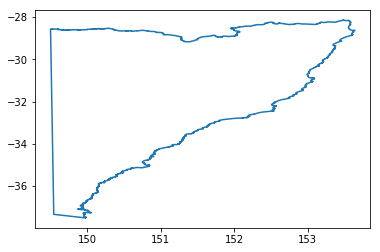

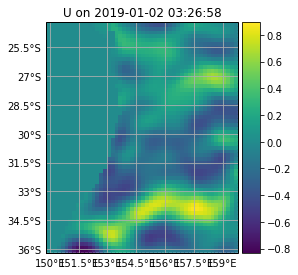

In [498]:
plt.plot(lon_nsw, lat_nsw)
fieldset_imos.U.show(domain={'N':-24, 'S':-36, 'E':160, 'W':150},land=False,show_time=12418+1*86400)

In [332]:
ds_ext['time'][0]

<xarray.DataArray 'time' ()>
array('2019-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-01-01

In [302]:
fieldset_ext.U.show(land=False)

In [341]:
"""
Compare before and after data extrapolation
"""

%matplotlib qt
fieldset_imos.U.show(domain={'N':-24, 'S':-36, 'E':160, 'W':150},land=False)
fieldset_ext.U.show(land=False)

In [355]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

"""
Create a set of particle
"""

pset = ParticleSet.from_list(fieldset=fieldset_ext, 
                             pclass=JITParticle,
                             lon=[151.565574],
                             lat=[-33.949705],
                             time=datetime(2019,1,1)) 

pset.show() #show particle before advection
print(pset) #print particle position before execution

"""
Execute advection and other kernels to the particle
"""
pset.execute(AdvectionRK4, #Only driven by currents
             runtime=timedelta(days=10), 
             dt=-timedelta(minutes=5), #if dt<0 : backwards tracking
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}, #Delete particles when out of bounds
             output_file=pset.ParticleFile(name="TRY.nc", outputdt=timedelta(hours=1)))
print(pset) #print particle position after execution
pset.show(show_time=10*86400)
"""
Execute advection and other kernels to the particle
"""
plotTrajectoriesFile('TRY.nc', mode='movie2d_notebook') #plot trajectory without the field on background


P[37](lon=151.565567, lat=-33.949703, depth=0.000000, time=0.000000)


INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-13529592/af4cd9990d75e1fb4da39d29c74a230f.so


P[37](lon=151.231827, lat=-35.364601, depth=0.000000, time=-864000.000000)


Traceback (most recent call last):
  File "/home/z3529592/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/z3529592/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/matplotlib/animation.py", line 1003, in _start
    self.event_source.add_callback(self._step)
AttributeError: 'NoneType' object has no attribute 'add_callback'


In [314]:
time[9]-time[8]

86400.0

In [359]:
"""
Advecting a particle and save its trajectory to gif
"""

pset = ParticleSet.from_list(fieldset=fieldset_ext,
                             pclass=JITParticle,
                             lon=[155.25,  153.25],
                             lat=[-33.57, -33.55],
                             time=datetime(2019,1,1))

images=[] #list to store images to create gif
for i in range(48):
    pset.execute(AdvectionRK4, runtime=timedelta(hours=i), dt=timedelta(hours=1), recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
    pset.show(savefile='../outputs_imos_current_data/make_gif/particle_try_'+str(i),field='vector', vmin=0., vmax=1.5,land=False,show_time=i*86400./24)
    images.append(imageio.imread('../outputs_imos_current_data/make_gif/particle_try_'+str(i)+'.png'))
imageio.mimsave('../outputs_imos_current_data/particle_advection_2days.gif', images) #create gif with all images

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-13529592/5f6c6a835b96e28545dfd3ea38387835.so
/home/z3529592/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/parcels/grid.py:144: RuntimeWarning: invalid value encountered in multiply
  nextTime_loc = np.infty * signdt
/home/z3529592/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  ----------
/home/z3529592/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  ----------
/home/z3529592/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/matplotlib/colors.py:509: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
INFO: Plot saved to ../outputs_imos_current_data/make_gif/particle_try_0.png
INFO: Plot saved to ../outputs_imos_current_data/make_gif/particle_try_1.png
INFO: Plot saved to ../outputs_imos_current_data/make_gif/particle_try_2.png
I

In [473]:
"""
Add brownian motion coefficient field to fieldset
"""

#from parcels import (FieldSet, AdvectionRK4, BrownianMotion2D, Field,
#                     ParticleSet, JITParticle, Variable, ErrorCode)

size2D = (fieldset_ext.U.grid.ydim, fieldset_ext.U.grid.xdim)
Kh_coeff=26.5 #coefficient of oceanic diffusion m^2.sec^-1
fieldset_ext.add_field(Field('Kh_zonal', data=Kh_coeff*np.ones(size2D),
                             lon=fieldset_ext.U.grid.lon, lat=fieldset_ext.U.grid.lat,
                             mesh='spherical', allow_time_extrapolation=True))
fieldset_ext.add_field(Field('Kh_meridional', data=Kh_coeff*np.ones(size2D),
                       
                             lon=fieldset_ext.U.grid.lon, lat=fieldset_ext.U.grid.lat,
                             mesh='spherical', allow_time_extrapolation=True))

In [376]:
"""
Advect particle set with current advection + brownian motion 
"""


pset = ParticleSet.from_list(fieldset=fieldset_ext,
                             pclass=JITParticle,
                             lon=[151.5,  151.5],
                             lat=[-33.6, -33.6],
                             time=[0,5])  

images=[]
pset.show(show_time=timedelta(days=0))

kernels=pset.Kernel(BrownianMotion2D)+pset.Kernel(AdvectionRK4) #add different kernels
pset.execute(kernels,
             runtime=timedelta(days=10),
             dt=timedelta(hours=5),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

pset.show(show_time=timedelta(days=10))
print(pset)

INFO: Compiled JITParticleBrownianMotion2DAdvectionRK4 ==> /tmp/parcels-13529592/56dda9f0ac1c6991e680876e31b197f8.so


P[58](lon=151.818390, lat=-32.857616, depth=0.000000, time=864000.000000)
P[59](lon=151.929962, lat=-32.904549, depth=0.000000, time=864000.000000)


In [372]:
mask_array.plot()

In [494]:
ds_ext['time']

<xarray.DataArray 'time' (time: 111)>
array(['2019-01-01T00:00:00.000000000', '2019-01-02T00:00:00.000000000',
       '2019-01-03T00:00:00.000000000', '2019-01-04T00:00:00.000000000',
       '2019-01-05T00:00:00.000000000', '2019-01-06T00:00:00.000000000',
       '2019-01-07T00:00:00.000000000', '2019-01-08T00:00:00.000000000',
       '2019-01-09T00:00:00.000000000', '2019-01-10T00:00:00.000000000',
       '2019-01-11T00:00:00.000000000', '2019-01-12T00:00:00.000000000',
       '2019-01-13T00:00:00.000000000', '2019-01-14T00:00:00.000000000',
       '2019-01-15T00:00:00.000000000', '2019-01-16T00:00:00.000000000',
       '2019-01-17T00:00:00.000000000', '2019-01-18T00:00:00.000000000',
       '2019-01-19T00:00:00.000000000', '2019-01-20T00:00:00.000000000',
       '2019-01-21T00:00:00.000000000', '2019-01-22T00:00:00.000000000',
       '2019-01-23T00:00:00.000000000', '2019-01-24T00:00:00.000000000',
       '2019-01-25T00:00:00.000000000', '2019-01-26T00:00:00.000000000',
       '2019-

In [493]:
"""
Create wind data and put it in a dataset
"""

#to replace with real wind data
size3D = (len(a),fieldset_ext.U.grid.ydim, fieldset_ext.U.grid.xdim)
u_values=-4*np.ones(size3D)
v_values=-4*np.ones(size3D)


u_wind=xr.DataArray(u_values,
                dims=['time','lat','lon'],
                coords={'time':a,
                        'lat':np.arange(-36,-24,0.1),
                        'lon':np.arange(150,160,0.1)},)     

v_wind=xr.DataArray(v_values,
                dims=['time','lat','lon'],
                coords={'time':a,
                        'lat':np.arange(-36,-24,0.1),
                        'lon':np.arange(150,160,0.1)},)   

#add to the existing dataset
ds_ext['u_wind']=u_wind
ds_ext['v_wind']=v_wind

#Mask data on land
ds_ext['u_wind_masked']=ds_ext['u_wind'].where(ds_ext.mask==2)
ds_ext['v_wind_masked']=ds_ext['v_wind'].where(ds_ext.mask==2)

"""
Add wind field to fieldset_ext
"""

fieldset_ext.add_field(Field('U_wind', data=ds_ext['u_wind_masked'], #meteorological huh ?
                             time=ds_ext['time'], lat=fieldset_ext.U.grid.lat,
                             lon=fieldset_ext.U.grid.lon,
                             mesh='spherical', transpose=True, allow_time_extrapolation=True))

fieldset_ext.add_field(Field('V_wind', data=ds_ext['v_wind_masked'],
                             time=ds_ext['time'], lat=fieldset_ext.U.grid.lat,
                             lon=fieldset_ext.U.grid.lon,
                             mesh='spherical', transpose=True, allow_time_extrapolation=True))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [428]:
, #meteorological huh ?
                             time=fieldset_ext.U.grid.time, lat=fieldset_ext.U.grid.lat,
                             lon=fieldset_ext.U.grid.lon,
                             mesh='spherical', transpose=True, allow_time_extrapolation=True)

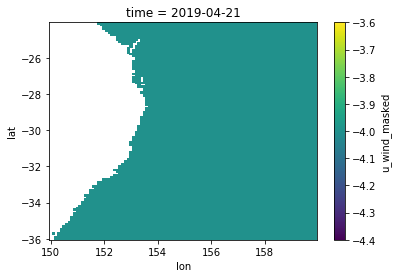

In [497]:
%matplotlib qt
ds_ext['u_wind_masked'][110].plot()

In [ ]:
def WindDrag(particle, fieldset, time):
    
    #constants
    S_x = 1.12e-4 #m^2 (from Daniel Lee)
    S_y = 5.5e-4 #m^2 (from Daniel Lee)
    S_w = 3.78e-4 #m^2 (from Daniel Lee)
    rho_a = 1.225 #kg.m^-3
    rho_w = 1030 #kg.m^-3
    
    #variables
    C_ax = 
    C_ay = 
    C_w = 
    theta = 
    
    coeff = np.divide(np.sqrt((S_x*C_ax)^2+ (S_y*C_ay)^2),S_w*C_w)
    vel_wind = np.sqrt((fieldset.U_wind[time, particle.lat, particle.lon])^2 + (fieldset.V_wind[time, particle.lat, particle.lon])^2)
    
    vel_bb = np.abs(vel_wind)*np.sqrt(rho_a/rho_w*coeff)
    
    particle.lon += particle.dt*(np.sin(theta)*vel_bb)
    particle.lat += particle.dt*(np.cos(theta)*vel_bb)

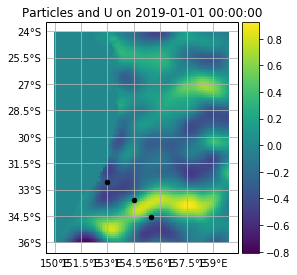

INFO: Compiled JITParticleWindDragAdvectionRK4BrownianMotion2D ==> /tmp/parcels-13529592/e75fd63e2f3b684a00cb8fdf5e3b2d69.so


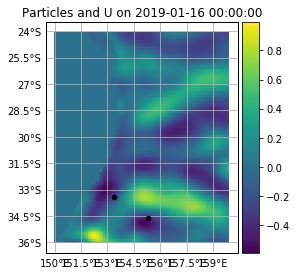

'\nfor i in range(48):\n    pset.execute(kernels, \n             runtime=timedelta(hours=i), \n             dt=-timedelta(hours=1), \n             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},\n             output_file=pset.ParticleFile(name="TR.nc", outputdt=timedelta(hours=1)))\n    pset.show(show_time=(time_ext[37]+i*86400/24),savefile=\'../outputs_imos_current_data/make_gif/particle_kernel_try_\'+str(i)+\'.png\', field=\'vector\', vmin=0., vmax=1.5,land=False)\n    images.append(imageio.imread(\'../outputs_imos_current_data/make_gif/particle_kernel_try_\'+str(i)+\'.png\'))\nimageio.mimsave(\'../outputs_imos_current_data/particle_advection_try.gif\', images)\n'

In [427]:
%matplotlib inline
import math

def WindDrag(particle, fieldset, time):
    
    wind_vel=0.35 #m.s^-1
    wind_dir_meteo=(54.9)*math.pi/180 #rad
    particle.lon += 0.04*wind_vel*math.cos(wind_dir_meteo)
    particle.lat += 0.04*wind_vel*math.sin(wind_dir_meteo)

pset = ParticleSet.from_list(fieldset=fieldset_ext,
                             pclass=JITParticle,
                             lon=[153,154.5,155.5], 
                             lat=[-32.57,-33.57,-34.55],
                             time=[datetime(2019,1,1),datetime(2019,1,2),datetime(2019,1,3)]) #first particle released time[0] the other time[2]
images=[]
pset.show(field=fieldset_ext.U,land=False,showtime=0)
kernels=pset.Kernel(WindDrag)+pset.Kernel(AdvectionRK4)+pset.Kernel(BrownianMotion2D)
pset.execute(kernels, 
             runtime=timedelta(days=15), 
             dt=timedelta(days=1), 
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
             output_file=pset.ParticleFile(name="TR.nc", outputdt=timedelta(days=1)))
            
pset.show(field=fieldset_ext.U, land=False, showtime=48*86400)

"""
for i in range(48):
    pset.execute(kernels, 
             runtime=timedelta(hours=i), 
             dt=-timedelta(hours=1), 
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
             output_file=pset.ParticleFile(name="TR.nc", outputdt=timedelta(hours=1)))
    pset.show(show_time=(time_ext[37]+i*86400/24),savefile='../outputs_imos_current_data/make_gif/particle_kernel_try_'+str(i)+'.png', field='vector', vmin=0., vmax=1.5,land=False)
    images.append(imageio.imread('../outputs_imos_current_data/make_gif/particle_kernel_try_'+str(i)+'.png'))
imageio.mimsave('../outputs_imos_current_data/particle_advection_try.gif', images)
"""

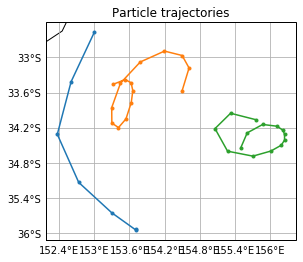

<module 'matplotlib.pyplot' from '/home/z3529592/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [424]:
plotTrajectoriesFile('TR.nc')

In [425]:
plotTrajectoriesFile('TR.nc', mode='movie2d_notebook')


In [221]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
# setup Lambert Conformal basemap.
# set resolution=None to skip processing of boundary datasets.
parallels = np.arange(-36,-24,1)
# labels = [left,right,top,bottom]
m = Basemap(width=1200000,height=1500000,projection='lcc',
            resolution='h',lat_1=-36,lat_2=-24,lat_0=-30,lon_0=155)
m.drawparallels(parallels)
meridians = np.arange(150,160.,5)
m.drawmeridians(meridians)

m.drawlsmask(land_color='coral',ocean_color='aqua',lakes=True)
plt.show()